In [1]:
# _importing required libraries

import pandas as pd
import os
import string
import numpy as np
import hdbscan

import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import spacy

from sklearn.metrics.pairwise import cosine_similarity

import texthero as hero
from texthero import preprocessing

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from gaussianlda import GaussianLDAAliasTrainer
from gaussianlda.model import GaussianLDA

import umap

import warnings
warnings.filterwarnings('ignore')

C:\Users\sri.sai.praveen.gadi\.virtualenvs\xxx-eAHl9Gue\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\sri.sai.praveen.gadi\.virtualenvs\xxx-eAHl9Gue\lib\site-packages\spacy\util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
C:\Users\sri.sai.praveen.gadi\.virtualenvs\xxx-eAHl9Gue\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMa

In [2]:
tf_model = hub.load(os.getcwd()+ '/../../models/USE_model')

In [2]:
keywords_df = pd.read_pickle(os.getcwd()+'/final_keywords_dataframe.pkl')
keywords_df = keywords_df[['id', 'keywords']]
keywords_df = keywords_df.rename(columns={'id': 'page_id'})

In [3]:
len(keywords_df.index)

26954

In [88]:
main_df = pd.read_pickle(os.getcwd()+'/../dataframes/retrieval_dataset.pkl')

In [119]:
mr_df = main_df[main_df['query'] == 'Mixed Reality']
vs_df = main_df[main_df['query'] == 'Visualisierung']

In [120]:
mr_df = pd.concat([mr_df.set_index('page_id'), keywords_df.set_index('page_id')], axis=1, join='inner').reset_index()
vs_df = pd.concat([vs_df.set_index('page_id'), keywords_df.set_index('page_id')], axis=1, join='inner').reset_index()

### 1. keyword extraction
### 2. Candidate pool extraction

In [28]:
def get_modified_vectors(vec_data):
    
    new_data = []
    for val in vec_data:
        new_data.append(val)
    
    new_data = np.array(new_data).reshape(-1, 512)
    return new_data

def get_pool_vec(doc_vec_list, pool):
    
    doc_vec_list = get_modified_vectors(doc_vec_list)
    if pool == 'mean':
        return np.nanmean(doc_vec_list, axis=0)
    elif pool == 'max':
        return np.nanmax(doc_vec_list, axis=0)

def get_document_vec(text):
    
    return tf_model(text)['outputs'].numpy()[0].reshape(1, -1)

def get_sent_transformers_keywords_use(keywords, query_vec, max_keyword_cnt = 30):
    
    keywords = list(dict(keywords).keys())
    
    candidate_embeddings_keywords = [tf_model(kw)['outputs'].numpy()[0] for kw in keywords]
        
    query_distances = cosine_similarity([query_vec], candidate_embeddings_keywords)
    subtopic_keywords_dict = dict()
    for index in query_distances.argsort()[0][-max_keyword_cnt:]: 
        
        subtopic_keywords_dict[keywords[index]] = query_distances[0][index]
    
    subtopic_keywords_dict = sorted(subtopic_keywords_dict.items(), key=lambda x: x[1], reverse=True)

    return subtopic_keywords_dict

def get_candidate_pool(subtopic_keywords_list):
    
    candidate_pool = []
    
    lower_limit = 0.2
    upper_limit = 0.4
    
    for key, value in subtopic_keywords_list:
        
        if value > 0.2 and value < 0.4:
            candidate_pool.append(key)
            
    return candidate_pool

In [98]:
query_1 = 'Mixed Reality'
query_vec_1 = tf_model(query_1)['outputs'].numpy()[0]

query_2 = 'Visualisierung'
query_vec_2 = tf_model(query_2)['outputs'].numpy()[0]

In [121]:
%timeit mr_df['keywords_use'] = mr_df.apply(lambda x:get_sent_transformers_keywords_use(x['keywords'], query_vec_1, max_keyword_cnt = 30), axis=1)

31.5 s ± 443 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [101]:
%timeit vs_df['keywords_use'] = vs_df.apply(lambda x:get_sent_transformers_keywords_use(x['keywords'], query_vec_1, max_keyword_cnt = 30), axis=1)

32.4 s ± 680 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [122]:
%timeit mr_df['candidate_pool'] = mr_df.apply(lambda x:get_candidate_pool(x['keywords_use']), axis=1)

3.05 ms ± 55 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [103]:
%timeit vs_df['candidate_pool'] = vs_df.apply(lambda x:get_candidate_pool(x['keywords_use']), axis=1)

3.02 ms ± 43.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
df_xlm = pd.read_pickle(os.getcwd()+'/final_dataframe.pkl')
df_xlm = df_xlm[['id', 'lang']]
df_xlm = df_xlm.rename(columns={'id': 'page_id'})

In [16]:
mr_df = pd.concat([mr_df.set_index('page_id'), df_xlm.set_index('page_id')], axis=1, join='inner').reset_index()
vs_df = pd.concat([vs_df.set_index('page_id'), df_xlm.set_index('page_id')], axis=1, join='inner').reset_index()

In [24]:
mr_df.to_pickle(os.getcwd()+'/../dataframes/retrieval_dataset_mr.pkl')
vs_df.to_pickle(os.getcwd()+'/../dataframes/retrieval_dataset_vs.pkl')

In [3]:
mr_df = pd.read_pickle(os.getcwd()+'/../dataframes/retrieval_dataset_mr.pkl')
vs_df = pd.read_pickle(os.getcwd()+'/../dataframes/retrieval_dataset_vs.pkl')

In [4]:
mr_df

,page_id,query,label,text,text_len,noun_chunks,mean_nc_vec,title,published_date,source_url,keywords,keywords_use,candidate_pool,lang,entities
0,210705_news_450807,Mixed Reality,2,Apple arbeitet an seinem ersten eigenen Mixed-...,333,"[Apple, sein erster eigen Mixed-Reality-Headse...","[[-0.008407283574342728, 0.005582862533628941,...",Apples Augmented-Reality-Headset angeblich mit...,2021-03-23 08:35:00,https://www.heise.de/news/Apples-Augmented-Rea...,"[(sein erster eigen Mixed-Reality-Headset, 0.3...","[(der geplant Mixed-Reality-Headset, 0.6080339...","[der Augmented-Reality-Technik, Zukunftsmusik,...",de,"[ORG, LOC, LOC, LOC, PER, MISC, ORG, MISC, MIS..."
1,210705_news_316645,Mixed Reality,3,Kampfflugzeuge sind seit jeher ein Symbol für ...,329,"[Kampfflugzeug, ein Symbol, national Hochtechn...","[[-0.020709725096821785, -0.000700523902196437...",Konzeptionelle Vorstellungen zum Future Comba...,2020-10-07 11:17:09,https://esut.de/2020/10/fachbeitraege/22981/ko...,"[(ein Future Combat Air, 0.60385466), (Kampffl...","[(der Einsatzrealität, 0.5460597), (kollaborat...","[kollaborativ Konzept, zunehmend hybrid prakti...",de,"[PER, ORG, PER, MISC, PER, MISC, LOC, LOC, LOC..."
2,210705_news_93916,Mixed Reality,4,"Die experimentelle Plattform namens ""Assembler...",284,"[der experimentell Plattform, --Assembler, For...","[[-0.018326913937926292, 0.001563811907544732,...",Google: Neue Plattform gegen Falschinformation...,2020-02-05 13:45:00,https://www.heise.de/newsticker/meldung/Deepfa...,"[(der Thema Falschinformations-Kampagn, 0.3010...","[(Deepfak, 0.47651172), (Fälschung, 0.40600026...","[Extremismus, Faktencheckern, verschieden Wiss...",de,"[MISC, ORG, ORG, PER, PER, ORG, LOC, LOC, LOC,..."
3,210705_news_223568,Mixed Reality,3,Im European Defence Industrial Development Pro...,275,[European Defence Industrial Development Progr...,"[[-0.010143241845071316, -0.001262652920559048...",Entwicklung eines europäischen unbemannten Bod...,2020-06-22 14:39:05,https://esut.de/2020/06/meldungen/21212/entwic...,[(European Defence Industrial Development Prog...,"[(künstlich Intelligenz, 0.3486532), (Milrem R...","[künstlich Intelligenz, Milrem Robotic, der Gr...",de,"[ORG, ORG, MISC, LOC, ORG, LOC, LOC, LOC, LOC,..."
4,210705_news_395875,Mixed Reality,3,DARPA’s Robotic Autonomy in Complex Environme...,228,"[DARPA’s Robotic Autonomy, Complex Environmen...","[[-0.020166562870144844, 0.0002533818187657743...",DARPA RACER-SIM,2021-01-20 11:37:10,https://euro-sd.com/2021/01/news/industry-news...,"[(DARPA’s Robotic Autonomy, 0.61190784), (RAC...","[(the real world, 0.5533277), (simulation, 0.4...",[a demonstrable simulation-to-real world capab...,en,"[ORG, ORG, DATE, CARDINAL, CARDINAL, PERSON, O..."
5,210705_news_418451,Mixed Reality,2,Plant Apple die Verwendung neuartiger Micro-OL...,379,"[Plant Apple, der Verwendung, neuartig Micro-O...","[[-0.008398597128689289, -0.001110038720071315...",Apples Augmented-Reality-Brille: Micro-OLEDs v...,2021-02-15 10:30:00,https://www.heise.de/news/Apple-Brille-Micro-O...,"[(neuartig Micro-OLED-Bildschirme, 0.47497174)...","[(Mixed-Reality-Erlebnisse, 0.80068773), (Mixe...","[der VR-Welt, diverser Patente, Sehstärke, der...",de,"[ORG, LOC, MISC, ORG, ORG, LOC, ORG, MISC, MIS..."
6,210705_news_420397,Mixed Reality,1,Das Technische Hilfswerk (THW) hat für die Aus...,260,"[der technisch Hilfswerk, --THW, der Ausbildun...","[[-0.022845558822155, 0.004152955021709204, -0...",Deichläuferausbildung mit Virtual Reality,2021-02-17 11:48:10,https://esut.de/2021/02/meldungen/25614/deichl...,[(der Virtual-Reality-Deichverteidigungs-Simul...,"[(Reality-Brillen, 0.52013505), (ein virtuell ...","[der Virtual-Reality-Trainingssystem, künstlic...",de,"[ORG, ORG, MISC, ORG, ORG, ORG, MISC, LOC, PER..."
7,210705_news_221064,Mixed Reality,1,"VIDEO In Mixed Reality News June 19, 2020 – ...",426,"[video, Mixed Reality News, MedCognition, a Te...","[[-0.008169465698301792, -0.000316161662340164...",MedCognition delivers Mixed Reali

In [6]:
vocab = []

for cp in mr_df.candidate_pool.values:
    vocab.extend(cp)
    
vocab = list(set(vocab))

In [10]:
vocab_embeddings = []

for cand in vocab:
    vocab_embeddings.append(tf_model(cand)['outputs'].numpy()[0])

In [11]:
corpus = []

for text in mr_df.candidate_pool.values:
    text_encoding = []
    
    for cp in text:
        text_encoding.append(vocab.index(cp))
    
    corpus.append(text_encoding)

In [34]:
vocab_embeddings.shape

(282, 512)

In [15]:
vocab_embeddings = np.array(vocab_embeddings)

In [36]:
vocab_embeddings_umap, umap_2 = get_umap_output(vocab_embeddings, dim_size=5)

In [51]:
output_dir = "glda_saved_model"
# Prepare a trainer
trainer = GaussianLDAAliasTrainer(
    corpus, vocab_embeddings_umap, vocab, 7, 0.01, 0.3, save_path=output_dir
)
# Set training running
trainer.sample(20)

model = GaussianLDA.load(output_dir)

iterations = 10
for doc in corpus:
    topics = model.sample(doc, iterations)
    print(topics)

2022-09-29 13:02:51,821 - GLDA - INFO - Initializing assignments
Initializing: 100% |||||||||||||||||||||||||||||||||||||||||||||| Time: 0:00:00
2022-09-29 13:02:51,965 - GLDA - INFO - Computing average LL
100% |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:00:00
2022-09-29 13:02:52,073 - GLDA - INFO - Average LL after initialization: -5.075e+00
2022-09-29 13:02:53,066 - GLDA - INFO - Iteration 0
Sampling: 100% |||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:00:00
2022-09-29 13:02:53,633 - GLDA - INFO - Computing average LL
100% |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:00:00
2022-09-29 13:02:53,754 - GLDA - INFO - Average LL: -4.644e+00
2022-09-29 13:02:53,756 - GLDA - INFO - Acceptance rate = 99.32%, mean acceptance: 1.15e+00 (438 samples draw)
2022-09-29 13:02:53,758 - GLDA - INFO - Prior select rate = 99.17%, mean select_pr = 0.99
2022-09-29 13:02:53,760 - GLDA - INFO - Chose new sample: 80.46%
2022-09-29 13:02:53,763 - GL

2022-09-29 13:02:59,996 - GLDA - INFO - Iteration 12
Sampling: 100% |||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:00:00
2022-09-29 13:03:00,341 - GLDA - INFO - Computing average LL
100% |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:00:00
2022-09-29 13:03:00,437 - GLDA - INFO - Average LL: -3.852e+00
2022-09-29 13:03:00,438 - GLDA - INFO - Acceptance rate = 80.77%, mean acceptance: 8.59e-01 (26 samples draw)
2022-09-29 13:03:00,440 - GLDA - INFO - Prior select rate = 99.01%, mean select_pr = 0.99
2022-09-29 13:03:00,442 - GLDA - INFO - Chose new sample: 3.64%
2022-09-29 13:03:00,443 - GLDA - INFO - Saving model
2022-09-29 13:03:00,524 - GLDA - INFO - Iteration 13
Sampling: 100% |||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:00:00
2022-09-29 13:03:00,844 - GLDA - INFO - Computing average LL
100% |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:00:00
2022-09-29 13:03:00,944 - GLDA - INFO - Average LL: -3.843e+00
2022-09-2

[3, 3, 3, 3, 3, 3]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 5, 0, 5, 5, 0, 0, 0, 5, 0, 5, 5, 5]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 2, 2, 2, 2]
[5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 2, 5, 5]
[3, 3, 3, 3, 3, 3]
[3, 3, 3, 3]
[3, 3, 3]
[5]
[2, 2, 2, 2, 2, 2]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[5, 5, 5, 5, 5, 2, 5, 5, 5, 2, 5, 5, 5, 5, 5, 2]
[3, 3, 3, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[5, 5, 5, 5, 5, 5]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[5, 5, 5, 5, 5]
[0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[5, 5, 5, 5]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 3, 3, 3, 3, 3]


In [42]:
mr_df.candidate_pool.values

array([list(['der Augmented-Reality-Technik', 'Zukunftsmusik', 'der Gesichtserkennung', 'ein direkt integriert Iris-Erkennung', 'ein hybrid Fresnel-Linsen-Designs', 'Young Optics']),
       list(['kollaborativ Konzept', 'zunehmend hybrid praktiziert Kriegführung', 'technologisch Dynamik', 'zukünftig Konflikt', 'Streitkraft', 'einiger Trend', 'Technologievorsprung', 'domänenübergreifend Fähigkeit', 'hochkomplex Waffensysteme', 'Technik', 'Rüstung', 'der zunehmend multifunktional Auslegung', 'der Luftkriegführung', 'Luft']),
       list(['Extremismus', 'Faktencheckern', 'verschieden Wissenschaftler', 'Enthauptungsvideo', 'Aufklärungsvideo', 'bestimmt Schwerpunkt', 'unterschiedlich Detektor', 'falsch Information', 'der Newsroom', 'dumm Kommentar', 'gezielt Kampagne', 'der Plattform', 'Forscher']),
       list(['künstlich Intelligenz', 'Milrem Robotic', 'der Grundlage', 'auch modern virtuell und konstruktiv Simulationsumgebung', 'Militärübung', 'der Land', 'der Projektphase', 'der estnisch

In [5]:
print(f'Retrieval score for Mixed reality: {mr_df.label.sum()}')
print(f'Retrieval score for Visualisierung: {vs_df.label.sum()}')

Retrieval score for Mixed reality: 73
Retrieval score for Visualisierung: 87


In [10]:
def get_irp(a, b):
    return ((a-b)/a)*100

In [21]:
nlp_de = spacy.load("de_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

In [22]:
def get_document_entities(text, lang):
    
    doc = None

    try:
        if len(text) >= 999999:
            return None

        if lang == 'en':
            doc = nlp_en(text)
        elif lang == 'de':
            doc = nlp_de(text)
        else:
            return None
        
        entities = []
        
        for ent in doc.ents:
            entities.append(ent.label_) 
    except Exception as e:
        return None
            
    return entities

In [23]:
mr_df['entities'] = mr_df.apply(lambda x:get_document_entities(x['text'], x['lang']),axis=1) 
vs_df['entities'] = vs_df.apply(lambda x:get_document_entities(x['text'], x['lang']),axis=1) 

### 3. Clustering

In [35]:
def get_umap_output(vec_array, dim_size=5):
    
    umap_obj = umap.UMAP(n_neighbors=40, 
                        n_components=dim_size, 
                        min_dist=0.01,
                        metric='cosine',
                        random_state=123).fit(vec_array) 
    
    umap_output = umap_obj.transform(vec_array) 
    return umap_output, umap_obj

def get_hdbscan_output(data_points, cluster_size=7):
    
    hdbscan_output = hdbscan.HDBSCAN(
        #min_cluster_size=cluster_size,
#                                       min_samples=2,
                                      metric='euclidean',
                                     cluster_selection_method='eom').fit(data_points)
    return hdbscan_output

def project_on_2Dplane(umap_output, cluster_ids):
    
    umap_df = pd.DataFrame(np.column_stack((umap_output, cluster_ids)), columns=['x', 'y', 'cluster ids'])
    grid = sns.FacetGrid(umap_df, hue='cluster ids', height=7)
    grid.map(plt.scatter, 'x', 'y').add_legend()
    
def get_clustering_analysis(cluster_df, final_candidate_pool_vecs, dimen_size=5, cluster_size=7):
    
    umap_output_5, umap_5 = get_umap_output(final_candidate_pool_vecs, dim_size=dimen_size)
    hdbscan_output = get_hdbscan_output(umap_output_5, cluster_size=cluster_size)
    
    cluster_df['cluster_id'] = hdbscan_output.labels_
#     cluster_df.cluster_id.hist(bins=150)
    
    umap_output_2, umap_2 = get_umap_output(final_candidate_pool_vecs, dim_size=2)
    project_on_2Dplane(umap_output_2, cluster_df['cluster_id'])
    
    return cluster_df

def get_nearest_keyword(keywords, keyword_vecs, mean_vec):
    
    query_distances = cosine_similarity([mean_vec], list(keyword_vecs))
    subtopic_keywords_dict = dict()
    for index in query_distances.argsort()[0]: 
        
        subtopic_keywords_dict[keywords[index]] = query_distances[0][index]
    
    subtopic_keywords_dict = sorted(subtopic_keywords_dict.items(), key=lambda x: x[1], reverse=True)
    return subtopic_keywords_dict[0][0]

def get_topics(cluster_data_df, candidate_pool):
    
    topic_list = []
    
    for idx, row in cluster_data_df.iterrows():
        
        candidate_words = row['candidate_words']
        topic = row['topic']
        
        for cp in candidate_pool:
            if cp in candidate_words:
                topic_list.append(topic)
                break
    
    return topic_list

def get_topic_documents(topic_words, final_df):
    
    doc_id_list = []
    for idx, row in final_df.iterrows():

        candidate_pool = row['candidate_pool']
        doc_id = row['page_id']

        for tw in topic_words:
            if tw in candidate_pool:
                doc_id_list.append(doc_id)

    return list(set(doc_id_list))

def get_meta_data(cluster_id, df, page_id_list):
    
    entity_list = []
    product_cnt = person_cnt = law_cnt = 0
    label_1 = label_2 = label_3 = label_4 = 0
    page_len = len(page_id_list)
    
    for page_id in page_id_list:
        entities = df[df['page_id'] == page_id]['entities'].values[0]
        
        product_cnt += entities.count('PRODUCT')
        person_cnt += entities.count('PERSON')
        law_cnt += entities.count('LAW')
        
        label = int(df[df['page_id'] == page_id]['label'].values[0])
        
        if label == 1:
            label_1 += 1
        elif label == 2:
            label_2 += 1
        elif label == 3:
            label_3 += 1
        elif label == 4:
            label_4 += 1
            
    return {
        'cluster_id': cluster_id,
        'product_cnt': product_cnt/page_len,
        'person_cnt': person_cnt/page_len,
        'law_cnt': law_cnt/page_len,
        'label_1': label_1,
        'label_2': label_2,
        'label_3': label_3,
        'label_4': label_4,
        'relevance_score': ((2*label_1)+(1*label_2)+(-1*label_3)+(-2*label_4)),
        
    }

def get_sub_topic_modelling(query_df):
    
    final_candidate_pool = []

    for idx, row in query_df.iterrows():
        final_candidate_pool.extend(row['candidate_pool'])
        
    final_candidate_pool = list(set(final_candidate_pool))

    final_candidate_pool_vecs = [tf_model(nc)['outputs'].numpy()[0] for nc in final_candidate_pool]

    df_data = []
    for word, vec in zip(final_candidate_pool, final_candidate_pool_vecs):
        df_data.append((word, vec))

    cluster_df = pd.DataFrame(df_data, columns= ['candidate_words', 'candidate_vecs'])
    cluster_df = get_clustering_analysis(cluster_df, final_candidate_pool_vecs, dimen_size=5, cluster_size=8)

    cluster_data = []

    for cluster_id in set(cluster_df.cluster_id.values):

        if cluster_id != -1:
            df = cluster_df[cluster_df['cluster_id'] == cluster_id]
            cluster_data.append((cluster_id, df.candidate_words.values, df.candidate_vecs.values))

    cluster_data_df = pd.DataFrame(cluster_data, columns=['cluster_id', 'candidate_words', 'candidate_vecs'])
    cluster_data_df['mean_vec'] = cluster_data_df.apply(lambda x:get_pool_vec(x['candidate_vecs'], 'mean'), axis=1)
    cluster_data_df['topic'] = cluster_data_df.apply(lambda x:get_nearest_keyword(x['candidate_words'], x['candidate_vecs'], x['mean_vec']), axis=1)

    cluster_data_df['page_id_list'] = cluster_data_df.apply(lambda x:get_topic_documents(x['candidate_words'], query_df), axis=1)
    cluster_data_df['doc_cnt'] = cluster_data_df.apply(lambda x:len(x['page_id_list']), axis=1)
    
    meta_data = []
    for idx, row in cluster_data_df.iterrows():
        meta_data.append(get_meta_data(row['cluster_id'], query_df, row['page_id_list']))
        
    entity_df = pd.DataFrame(meta_data)
    cluster_data_df = pd.concat([cluster_data_df.set_index('cluster_id'), entity_df.set_index('cluster_id')], axis=1, join='inner').reset_index()
      
    return cluster_data_df

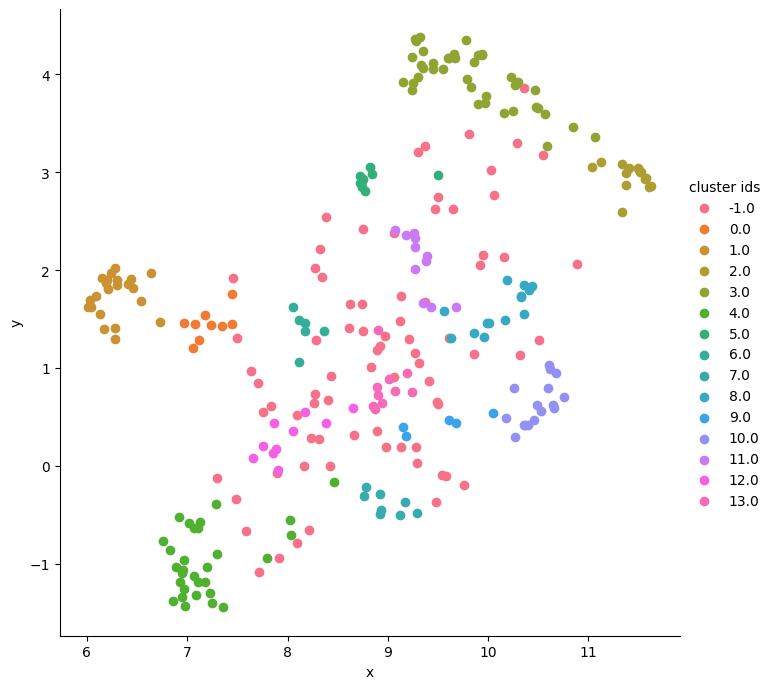

In [168]:
cluster_data_df_mr = get_sub_topic_modelling(mr_df)
# cluster_data_df_vs = get_sub_topic_modelling(vs_df)

In [153]:
columns = ['cluster_id', 'topic','doc_cnt', 'relevance_score','label_1','label_2','label_3','label_4', 'product_cnt', 'person_cnt', 'law_cnt']

In [154]:
cluster_data_df_mr[columns]

,cluster_id,topic,doc_cnt,relevance_score,label_1,label_2,label_3,label_4,product_cnt,person_cnt,law_cnt
0,0,nucleation rate,2,-3,0,0,1,1,0.500000,1.000000,0.000000
1,1,algebra,3,-6,0,0,0,3,4.666667,46.666667,1.000000
2,2,a simulation model,5,3,3,0,1,1,0.400000,1.400000,0.200000
3,3,VR,11,7,4,3,4,0,0.545455,5.909091,0.181818
4,4,"ubiquitous, diversity-relate training",8,-5,2,0,3,3,0.125000,5.875000,0.500000
5,5,3D-Druck,6,4,2,2,2,0,0.000000,1.500000,0.166667
6,6,AR,5,-2,0,2,2,1,0.600000,3.600000,0.000000
7,7,autonomous platform,5,-3,1,0,3,1,0.000000,0.400000,0.200000
8,8,Neural Rendering,8,0,2,2,2,2,0.250000,3.625000,0.375000
9,9,der Zukunft,5,2,1,2,2,0,0.200000,0.600000,0.000000


In [175]:
def get_elimination_cluster_cnt(df):
    
    cluster_cnt_perfect = cluster_cnt_relevant = 0
    neg_doc_eliminated_perfect = []
    neg_doc_eliminated_relevant = []
    
    for idx, row in df.iterrows():
        
        label_1 = row['label_1']
        label_2 = row['label_2']
        label_3 = row['label_3']
        label_4 = row['label_4']
                
        if label_1 == 0:
            cluster_cnt_perfect += 1
            if label_2 == 0:
                cluster_cnt_relevant += 1
                
                neg_doc_eliminated_relevant.extend(row['page_id_list'])
                
            neg_doc_eliminated_perfect.extend(row['page_id_list'])
                
    return cluster_cnt_perfect, len(set(neg_doc_eliminated_perfect)), cluster_cnt_relevant, len(set(neg_doc_eliminated_relevant))

LM - USE, Roberta, flair, mpnet
DR - 8 to 16 settings - reasonable paramter setting - from literature
clustering - 4 * 3 - 12

In [170]:
get_elimination_cluster_cnt(cluster_data_df_mr)

(4, 12, 2, 5)

In [177]:
cluster_data_df_vs[columns]

,cluster_id,topic,doc_cnt,relevance_score,label_1,label_2,label_3,label_4,product_cnt,person_cnt,law_cnt
0,0,peripheral color perception,3,1,1,1,0,1,0.333333,10.333333,0.000000
1,1,VR display,3,2,1,1,1,0,0.333333,4.000000,0.000000
2,2,ein 3D-Visualisierung,7,-1,2,1,2,2,0.285714,2.142857,0.000000
3,3,Natural Scenes,2,1,1,0,1,0,0.500000,5.500000,0.000000
4,4,Gehirn,3,-1,0,1,2,0,0.000000,2.000000,0.000000
5,5,digital Einzigartigkeit,5,-7,0,1,0,4,0.000000,0.000000,0.000000
6,6,Simulatoren,1,1,0,1,0,0,0.000000,0.000000,0.000000
7,7,mehrere Roboter,6,-2,1,1,3,1,0.000000,0.000000,0.000000
8,8,der Projekt,9,-12,0,1,3,5,0.000000,1.000000,0.666667
9,9,video,3,0,1,0,2,0,0.333333,5.333333,0.000000


In [171]:
get_elimination_cluster_cnt(cluster_data_df_vs)

(6, 19, 1, 10)

In [155]:
cluster_data_df_mr[columns].describe()

,cluster_id,doc_cnt,relevance_score,label_1,label_2,label_3,label_4,product_cnt,person_cnt,law_cnt
count,14.0000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,6.5000,6.000000,-0.214286,1.428571,1.285714,2.214286,1.071429,0.588876,6.175479,0.256439
std,4.1833,2.601775,4.209487,1.222500,1.325987,1.476929,1.071612,1.204264,11.957039,0.296810
min,0.0000,2.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.2500,5.000000,-3.000000,0.250000,0.000000,1.250000,0.000000,0.025000,1.100000,0.000000
50%,6.5000,5.500000,-1.500000,1.500000,1.500000,2.000000,1.000000,0.225000,3.050000,0.190909
75%,9.7500,7.750000,2.750000,2.000000,2.000000,2.750000,1.750000,0.534091,5.334821,0.356250
max,13.0000,11.000000,7.000000,4.000000,4.000000,6.000000,3.000000,4.666667,46.666667,1.000000


In [77]:
#  cluster_data_df_mr.boxplot(column=['product_cnt', 'person_cnt', 'law_cnt'])

In [156]:
cluster_data_df_mr[['doc_cnt', 'relevance_score','label_1','label_2','label_3','label_4', 'product_cnt', 'person_cnt', 'law_cnt']].corr()

,doc_cnt,relevance_score,label_1,label_2,label_3,label_4,product_cnt,person_cnt,law_cnt
doc_cnt,1.000000,0.344155,0.701352,0.535130,0.740678,-0.055180,-0.306040,-0.288658,0.045731
relevance_score,0.344155,1.000000,0.661976,0.714656,-0.053910,-0.729607,-0.281333,-0.371604,-0.512523
label_1,0.701352,0.661976,1.000000,0.298279,0.243450,-0.142601,-0.294241,-0.330188,0.024412
label_2,0.535130,0.714656,0.298279,1.000000,0.241284,-0.610955,-0.155829,-0.219576,-0.466567
label_3,0.740678,-0.053910,0.243450,0.241284,1.000000,-0.156223,-0.486170,-0.391508,-0.123831
label_4,-0.055180,-0.729607,-0.142601,-0.610955,-0.156223,1.000000,0.455509,0.487131,0.831166
product_cnt,-0.306040,-0.281333,-0.294241,-0.155829,-0.486170,0.455509,1.000000,0.953579,0.627961
person_cnt,-0.288658,-0.371604,-0.330188,-0.219576,-0.391508,0.487131,0.953579,1.000000,0.676839
law_cnt,0.045731,-0.512523,0.024412,-0.466567,-0.123831,0.831166,0.627961,0.676839,1.000000


In [157]:
def get_elimination_pool(df, column_name, quantile):
    
    df = df[df[column_name] > quantile]
    
    elimination_pool = []
    for page_id in df.page_id_list.values:
        elimination_pool.extend(page_id)
    
    return list(set(elimination_pool))

In [158]:
def get_retrieval_updates(percentile):
    
    law_cnt_75 = cluster_data_df_mr.law_cnt.quantile(percentile)
#     person_cnt_75 = cluster_data_df_mr.person_cnt.quantile(percentile)
    product_cnt_75 = cluster_data_df_mr.product_cnt.quantile(percentile)

    law_elimination_pool = get_elimination_pool(cluster_data_df_mr, 'law_cnt', law_cnt_75)
#     person_elimination_pool = get_elimination_pool(cluster_data_df_mr, 'person_cnt', person_cnt_75)
    product_elimination_pool = get_elimination_pool(cluster_data_df_mr, 'product_cnt', product_cnt_75)

    elimination_pool = list(set(law_elimination_pool) & set(product_elimination_pool))

    elm_df = mr_df[mr_df['page_id'].isin(elimination_pool)]
    print(elm_df.label.value_counts())

In [159]:
for prnt in np.arange(0.1, 1, 0.02):
    
    prnt = round(prnt, 2)
    print(f'\n{prnt} ==== ')
    get_retrieval_updates(prnt)


0.1 ==== 
2    7
3    7
4    6
1    5
Name: label, dtype: int64

0.12 ==== 
2    7
3    7
4    6
1    5
Name: label, dtype: int64

0.14 ==== 
2    7
3    7
4    6
1    5
Name: label, dtype: int64

0.16 ==== 
2    7
3    7
4    6
1    5
Name: label, dtype: int64

0.18 ==== 
2    7
3    7
4    6
1    5
Name: label, dtype: int64

0.2 ==== 
2    7
3    7
4    6
1    5
Name: label, dtype: int64

0.22 ==== 
2    7
3    7
4    6
1    5
Name: label, dtype: int64

0.24 ==== 
2    7
3    7
4    6
1    5
Name: label, dtype: int64

0.26 ==== 
2    7
3    7
4    6
1    5
Name: label, dtype: int64

0.28 ==== 
2    7
3    7
4    6
1    5
Name: label, dtype: int64

0.3 ==== 
2    7
3    7
4    6
1    5
Name: label, dtype: int64

0.32 ==== 
2    7
3    7
4    6
1    5
Name: label, dtype: int64

0.34 ==== 
2    7
3    7
4    6
1    5
Name: label, dtype: int64

0.36 ==== 
2    7
3    7
4    6
1    5
Name: label, dtype: int64

0.38 ==== 
2    7
3    7
4    6
1    5
Name: label, dtype: int64

0.4 ==== 
2 